In [1]:
import pandas as pd 
import numpy as np
import degree_codes as dc
import matplotlib.pyplot as plt
plt.style.use('seaborn-dark-palette')
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.combine import SMOTETomek
from sklearn.neural_network import MLPClassifier
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from dmba import classificationSummary, gainsChart
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
import pprint
from sklearn.svm import SVC  

In [153]:
df=pd.read_csv('main_df.csv')
df.head(3)

,YEAR,MULTYEAR,SAMPLE,SERIAL,CBSERIAL,HHWT,CLUSTER,STATEFIP,STRATA,GQ,...,INCWAGE,State,under_represented,domestic_born,EDU_verbose,is_STEM_degree,Degree,Degree_D,JobRole,stemType
0,2020,2016,202003,6676264,2016000978820,5.15,2020066762643,55,10055,1,...,51776,Wisconsin,0,1,High School,0,NaN,NaN,couriers and messengers,-1
1,2020,2016,202003,4027595,2016000661290,17.51,2020040275953,36,60036,1,...,21573,New York,0,1,High School,0,NaN,NaN,miscellaneous production workers including equ...,-1
2,2020,2017,202003,5156019,2017000181278,6.18,2020051560193,42,370142,1,...,0,Pennsylvania,0,0,Bachelor,0,Criminal Justice and Fire Protection,Criminal Justice and Fire Protection,elementary and middle school teachers,-1


In [154]:
#selecting the feautures for modeling
df_model=df[[
    'SEX'
    #,'RACE'
    ,'AGE'
    ,'domestic_born'
    ,'EDU_verbose'
    ,'is_STEM_degree'
    ,'under_represented'
    ,'stemType'
]]
del df

In [4]:
df_model['stemType'].value_counts()

-1                                                                                 189173
Research, Development, Design, and Practitioners                                     4052
Managerial                                                                            768
Research, Development, Design, and Practitioners; Technologists and Technicians       612
Technologists and Technicians                                                         355
Sales                                                                                  39
Name: stemType, dtype: int64

In order to run any sort of modeling on stemType, our target variable, we have to binarize it by employing a lambda function. At this point, stemType indicates whether an individual works in STEM, rather than which STEM field they're employed in :

In [156]:
def binarize_stem(x):
    if x == '-1':
        return 0
    return 1

#binarize STEM
df_model['stemType'] = df_model['stemType'].map(binarize_stem)

df_model['stemType'].head(3)

0    0
1    0
2    0
Name: stemType, dtype: int64

In order to deploy our ML model online, we need to save a version of our full dataset that enables the user to define the value for each feature before we do encoding for EDU_verbose.

In [183]:
df_model.to_csv('streamlit/data.csv',index=None)

Given that there's several different levels of education, we would benefit from using dummy variables in our modeling for them:

In [6]:
#a = pd.get_dummies(df_model['RACE'], prefix = "RACE")# get dummy variables for Race
b = pd.get_dummies(df_model['EDU_verbose'],prefix='EDU_verbose')#get dummy variables for Education

frames = [
    df_model
    #, a
    , b] # append them as a list
df_model = pd.concat(frames, axis = 1)
df_model=df_model.drop(columns = [
    'EDU_verbose'
    #, 'RACE'
]) 

Finally, to keep scale consistent, we would want to normalize the AGE variable to avoid giving it more weight. We can do this by subtracting the mean and dividing by the standard devation:

In [12]:
print(f"Age Std. Dev:{df_model['AGE'].std()}")
print(f"Mean Age:{df_model['AGE'].mean()}")

Age Std. Dev:18.939649284403245
Mean Age:50.02754885922492


In [13]:
df_model['AGE'] = (df_model['AGE']-df_model['AGE'].mean())/df_model['AGE'].std()
df_model['AGE'].head(3)

0    0.156943
1    0.315341
2   -0.793444
Name: AGE, dtype: float64

In [14]:
y=df_model['stemType']
y.value_counts()

0    189173
1      5826
Name: stemType, dtype: int64

### Check for class imbalance 

Percent of 0s: 97.01

Percent of 1s: 2.99


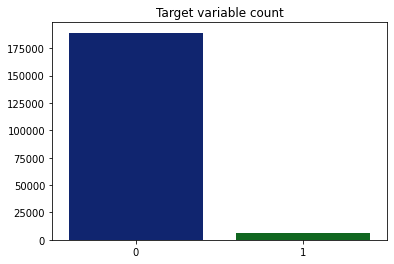

In [15]:
data = pd.DataFrame(df_model['stemType'])
percentage1 = round((data.stemType.sum() / data.shape[0]) * 100, 2) 
percentage0 = round(100 - percentage1, 2)
print('Percent of 0s:', percentage0)
print('\nPercent of 1s:', percentage1)
t=df_model['stemType'].value_counts().values
sns.barplot([0,1],t)
plt.title('Target variable count')
plt.show()

In [16]:
X = df_model.drop(columns=['stemType'])
y = df_model['stemType']
train_X, rem_X, train_y, rem_y = train_test_split(X, y, train_size=0.6, random_state=42, stratify = y)
valid_X, test_X, valid_y, test_y = train_test_split(rem_X, rem_y, train_size=0.5, random_state=42, stratify = rem_y) 

In [17]:
print('Training Set:\n', train_y.value_counts(), '\n', train_y.value_counts(normalize = True))
print('\nValidation Set:\n', valid_y.value_counts(), '\n', valid_y.value_counts(normalize = True))
print('\nTest Set:\n', test_y.value_counts(), '\n', test_y.value_counts(normalize = True))

Training Set:
 0    113503
1      3496
Name: stemType, dtype: int64 
 0    0.970119
1    0.029881
Name: stemType, dtype: float64

Validation Set:
 0    37835
1     1165
Name: stemType, dtype: int64 
 0    0.970128
1    0.029872
Name: stemType, dtype: float64

Test Set:
 0    37835
1     1165
Name: stemType, dtype: int64 
 0    0.970128
1    0.029872
Name: stemType, dtype: float64


In [ ]:
try:
    train_X_res = pd.read_csv('SMOTE_df.csv')
    train_y_res = pd.read_csv('SMOTE_df_target.csv')
except:
    print("using SMOTE to rebalance...")
    # Fixing the class imbalance with tomekLinks and SMOTE
    SMOTEtl = SMOTETomek(random_state = 42)

    # fit predictor and target variable for training set only
    train_X_res, train_y_res = SMOTEtl.fit_resample(train_X, train_y)

    print('Original dataset shape:\n', train_y.value_counts())
    print('Resampled dataset shape:\n', train_y_res.value_counts())

    train_X_res.to_csv('SMOTE_df.csv',index=None)
    train_y_res.to_csv('SMOTE_df_target.csv',index=None)

In [21]:
train_X_res.head()

,SEX,AGE,domestic_born,is_STEM_degree,under_represented,EDU_verbose_Associate,EDU_verbose_Bachelor,EDU_verbose_High School,EDU_verbose_Master,EDU_verbose_None/Below HS,EDU_verbose_PhD
0,-1,-0.212652,1,0,1,0,0,0,0,1,0
1,0,1.318528,0,0,0,0,0,1,0,0,0
2,-1,0.051345,1,0,0,0,0,1,0,0,0
3,-1,2.321714,1,0,0,0,0,0,0,0,1
4,-1,1.846521,1,0,0,0,0,0,0,1,0


We can also save our SMOTE data to .csv to avoid having to re-run this data during development work for future replications, which is handled in the **except** statement above.

### Helper Function: Confusion Matrix

In [22]:
def confusionMatrices(model, title):
    print(title + ' - training results')
    classificationSummary(train_y_res, model.predict(train_X_res))
    print(title + ' - validation results')
    valid_pred = model.predict(valid_X)
    classificationSummary(valid_y, valid_pred)

### Helper Function: Evaluation Metrics

In [64]:
def evalMetrics(model,mod_predict,verbose=True):
    # precision tp / (tp + fp)
    precision = precision_score(test_y, mod_predict)
    # recall: tp / (tp + fn)
    recall = recall_score(test_y, mod_predict)
    
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(test_y, mod_predict)
    
    # ROC AUC
    mp = model.predict_proba(test_X)
    mp = mp[:, 1]
    auc = roc_auc_score(test_y, mp)
    
    if verbose:
        print('Precision: %f' % precision)
        print('Recall: %f' % recall)
        print('F1 score: %f' % f1)
        print('ROC AUC: %f' % auc)
        
    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc":auc
    }

### Helper Function: Performance Plotting

In [146]:
def roc_vs(roc_scores,params,param_name):
    # plot
    plt.plot(params,roc_scores)
    max_roc = max(roc_scores)
    max_index = roc_scores.index(max_roc)
    
    try:
        max_param = round(params[max_index],4)
    except:
        max_param = params[max_index]
        
    max_roc = round(max_roc,4)
    plt.ylabel('roc-auc')
    plt.xlabel(param_name)
    plt.title(f'roc-auc score vs {param_name}, max roc:{max_roc}, parameter: {max_param}')
    plt.show()

### Naive Bayes

In [24]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(train_X_res, train_y_res)
confusionMatrices(gnb,'Naive Bayes')

Naive Bayes - training results
Confusion Matrix (Accuracy 0.7335)

       Prediction
Actual     0     1
     0 81792 31656
     1 28822 84626
Naive Bayes - validation results
Confusion Matrix (Accuracy 0.7251)

       Prediction
Actual     0     1
     0 27454 10381
     1   340   825


#### Evaluation and Confusion Matrix:

In [65]:
gnb_pred = gnb.predict(test_X)
evalMetrics(gnb,gnb_pred,False)

{'precision': 0.0749890877346137,
 'recall': 0.7373390557939914,
 'f1': 0.13613312202852615,
 'roc_auc': 0.8162830360652278}

### Logistic Regression - Initial Overview and Tuning

In [35]:
C_param_range = [0.001,0.01,0.1,1,10,100]
roc_scores = []
for c in C_param_range:

    logit_reg = LogisticRegression(
        penalty="elasticnet"
        , C=c
        , solver='saga'
        , random_state = 1
        , l1_ratio = 0.5
    )
    logit_reg.fit(train_X_res, train_y_res)
    #confusionMatrices(logit_reg, 'Logistic regression')
    logit_pred = logit_reg.predict(test_X)
    roc_scores.append(evalMetrics(logit_reg,logit_pred,False)['roc_auc'])

In [39]:
print(max(roc_scores))

0.8319343478657895


#### Deep Search

In [54]:
parameters = {
                'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                'penalty':['none', 'elasticnet', 'l1', 'l2'],
                'C':[0.0001, 0.0005, 0.001, 0.005, 0.01]
             }



grid_search = GridSearchCV(
    estimator = LogisticRegression(random_state=1),  
    param_grid = parameters,
    scoring = 'roc_auc',
    cv = 5,
    verbose=0)


grid_search.fit(train_X_res, train_y_res)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=1),
             param_grid={'C': [0.0001, 0.0005, 0.001, 0.005, 0.01],
                         'penalty': ['none', 'elasticnet', 'l1', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             scoring='roc_auc')

In [58]:
print(grid_search.best_estimator_)

LogisticRegression(C=0.0001, penalty='none', random_state=1)


In [60]:
lr = LogisticRegression(random_state=1,C=0.0001,penalty='none')
lr.fit(train_X_res,train_y_res)
logit_pred = logit_reg.predict(test_X)
evalMetrics(logit_reg,logit_pred,False)

{'precision': 0.09274238227146814,
 'recall': 0.7184549356223175,
 'f1': 0.16427870461236507,
 'roc_auc': 0.8319209170608091}

### Random Forest - GridSearch

To optimize random forest performance, we want to cycle through the number of estimators, the maximum tree depth, the log-loss, the cost function, and more:

In [21]:
rf = RandomForestClassifier(random_state = 1,verbose = 2)

# Number of trees in random forest
n_estimators = [400,450,500,550,600]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 10, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint.pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [400, 450, 500, 550, 600]}


In [ ]:
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(
    estimator = rf
    , param_distributions = random_grid
    , n_iter = 100
    , cv = 3
    , verbose=2
    , random_state=1
    , n_jobs = -1
    , scoring = 'roc_auc'
)
# Fit the random search model
rf_random.fit(train_X_res, train_y_res)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


We can see which parameters perform the best for our random forest:

Continue by reviewing the array of ROC scores we got from our models:

In [ ]:
RandomForest_pred = rf_random.predict(test_X)

In [ ]:
evalMetrics(rf_random,RandomForest_pred)
classificationSummary(test_y, RandomForest_pred)

We can also compare this with our original model:

In [ ]:
#current best roc ~ 83.7%
RandomForest = RandomForestClassifier(
    n_estimators=500 #current best = 500
    , random_state=1
    , max_depth = 6
)
RandomForest.fit(train_X_res, train_y_res)
RandomForest_pred = RandomForest.predict(test_X)
evalMetrics(RandomForest,RandomForest_pred)
classificationSummary(test_y, RandomForest_pred)

it appears that despite our eforts to conduct some sort of gridsearch for our random forest model, we're unable to beat the roc of 83.7% using conventional means, and will have to approach this more carefully by tuning each metric alone until we get better insights.

#### 1. Number of Estimators

In [129]:
estimators = [125,150,175,200,225,250]
roc_scores = []

for e in estimators:
    RandomForest = RandomForestClassifier(
        n_estimators= e #current best = 500
        , random_state=1
        , max_depth = 6
    )
    RandomForest.fit(train_X_res, train_y_res)
    RandomForest_pred = RandomForest.predict(test_X)
    
    #get roc_auc
    this_roc = evalMetrics(RandomForest,RandomForest_pred,verbose=False)['roc_auc']
    roc_scores.append(this_roc)

#### 1b. Visualization

we can conclude that around 200 estimators is an optimal number for our random forest clasifier.

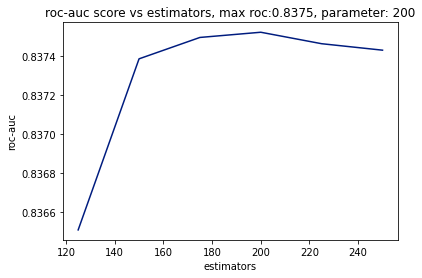

In [130]:
roc_vs(roc_scores,estimators,"estimators")

#### 2. max depth

In [131]:
depths = list(range(1,10))
roc_scores = []

for d in depths:
    RandomForest = RandomForestClassifier(
        n_estimators= 200 #current best = 500
        , random_state=1
        , max_depth = d
    )
    RandomForest.fit(train_X_res, train_y_res)
    RandomForest_pred = RandomForest.predict(test_X)
    
    #get roc_auc
    this_roc = evalMetrics(RandomForest,RandomForest_pred,verbose=False)['roc_auc']
    roc_scores.append(this_roc)

#### 2b. Visualization

a max depth of 7 seems to be an optimal parameter at this stage.

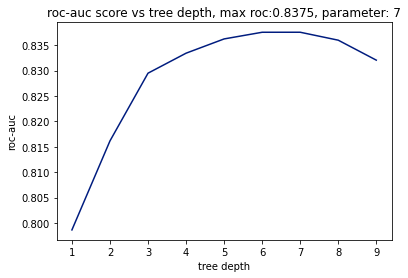

In [132]:
roc_vs(roc_scores,depths,"tree depth")

#### 3. Min sample split

In [137]:
min_samples_split = list(range(22,40,2))
roc_scores = []

for m in min_samples_split:
    RandomForest = RandomForestClassifier(
        n_estimators= 200
        , random_state=1
        , max_depth = 7
        , min_samples_split = m
    )
    RandomForest.fit(train_X_res, train_y_res)
    RandomForest_pred = RandomForest.predict(test_X)
    
    #get roc_auc
    this_roc = evalMetrics(RandomForest,RandomForest_pred,verbose=False)['roc_auc']
    roc_scores.append(this_roc)

#### 3b. Visualization
Optimal performance seems to be at a min-sample split of 24.

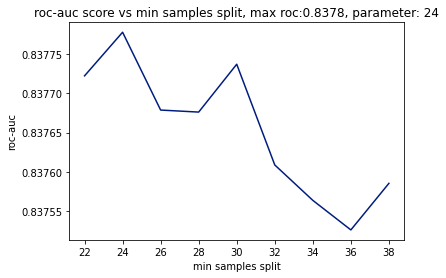

In [138]:
roc_vs(roc_scores,min_samples_split,"min samples split")

#### 4. Min samples per leaf

In [139]:
# Minimum number of samples required at each leaf node
min_samples_leaf = [1,5,10,20,30,40,50,60,70,80,90,100,150,175,200,250,300]
roc_scores = []

for m in min_samples_leaf:
    RandomForest = RandomForestClassifier(
        n_estimators= 200
        , random_state=1
        , max_depth = 7
        , min_samples_split = 24
        , min_samples_leaf=m
    )
    RandomForest.fit(train_X_res, train_y_res)
    RandomForest_pred = RandomForest.predict(test_X)
    
    #get roc_auc
    this_roc = evalMetrics(RandomForest,RandomForest_pred,verbose=False)['roc_auc']
    roc_scores.append(this_roc)

#### 4b. Visualization
150 samples per leaf at a minimum is an optimal parameter.

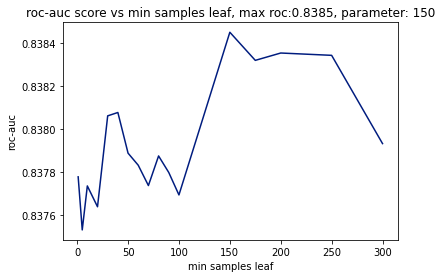

In [140]:
roc_vs(roc_scores,min_samples_leaf,"min samples leaf")

#### 5. criterion for splitting

In [141]:
# Minimum number of samples required at each leaf node
criteria = ["gini","entropy","log_loss"]
roc_scores = []

for c in criteria:
    RandomForest = RandomForestClassifier(
        n_estimators= 200
        , random_state=1
        , max_depth = 7
        , min_samples_split = 24
        , min_samples_leaf=150
        , criterion = c 
    )
    RandomForest.fit(train_X_res, train_y_res)
    RandomForest_pred = RandomForest.predict(test_X)
    
    #get roc_auc
    this_roc = evalMetrics(RandomForest,RandomForest_pred,verbose=False)['roc_auc']
    roc_scores.append(this_roc)

#### 5b. Visualization
In conclusion, any criterion except gini is sufficient for optimization.

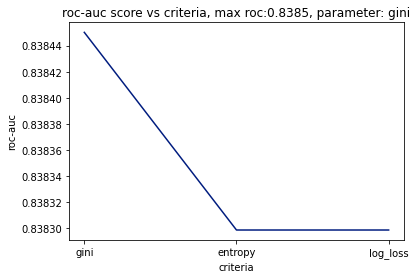

In [147]:
roc_vs(roc_scores,criteria,"criteria")

#### Conclusion
Despite several different layers of optimization work, the final conclusion for our random forest model is an ROC-AUC of 83.85%.

### Neural Network

In [ ]:
neuralNet = MLPClassifier(
    hidden_layer_sizes=(5)
    , activation='logistic'
    , solver='adam'
    , max_iter=2000, 
    random_state=1
)
neuralNet.fit(train_X_res, train_y_res)
confusionMatrices(neuralNet, 'Neural Network')

In [ ]:
neuralNet_pred = neuralNet.predict(test_X)
classificationSummary(test_y, neuralNet_pred )
evalMetrics(neuralNet,neuralNet_pred)

Our neural network has an roc-auc of 84%, which is very similar to our random forest model. Here, we can take some steps to optimize our neural network by changing the number of hidden layers, the number of units, the learning rate, and more.

#### 1. Hidden Layer Units

In [ ]:
sizes = [1,2,3,4,5,10,15]
roc_scores = []

for size in sizes:
    neuralNet = MLPClassifier(
        hidden_layer_sizes=(size)
        , activation='logistic'
        , solver= 'adam'#'lbfgs'
        , max_iter=2000, 
        random_state=1
    )
    neuralNet.fit(train_X_res, train_y_res)
    #confusionMatrices(neuralNet, 'Neural Network')
    neuralNet_pred = neuralNet.predict(test_X)
    this_roc = evalMetrics(neuralNet,neuralNet_pred,verbose=False)['roc_auc']
    roc_scores.append(this_roc)

#### 1b. Visualization
Having 10 nodes in our hidden layer creates the best performance.

In [ ]:
# plot
plt.plot(sizes,roc_scores)
plt.title(f'roc-auc score vs hidden layer size, max:{max(roc_scores)}')
plt.show()

#### 2. Max Iterations

In [ ]:
its =  [int(x) for x in np.linspace(100, 5000, num = 20)]
roc_scores = []

for it in its:
    neuralNet = MLPClassifier(
        hidden_layer_sizes=(10)
        , activation='logistic'
        , solver='adam'
        , max_iter=it, 
        random_state=1
    )
    neuralNet.fit(train_X_res, train_y_res)
    #confusionMatrices(neuralNet, 'Neural Network')
    neuralNet_pred = neuralNet.predict(test_X)
    this_roc = evalMetrics(neuralNet,neuralNet_pred,verbose=False)['roc_auc']
    roc_scores.append(this_roc)

#### 2b. Visualization

100 iterations is ideal for optimizing our roc-auc scores.

In [ ]:
# plot
plt.plot(its,roc_scores)
plt.title(f'roc-auc score vs max iterations, max:{max(roc_scores)}')
plt.show()

#### 3. Alpha Selection 
Context: In this model, the Alpha is the strength of the L2 regularization, which removes a small portion of the weights without ever going down to zero.

In [ ]:
alphas =  [float(x) for x in np.linspace(0.01, 0.1, num = 10)] 
roc_scores = []

for alpha in alphas:
    neuralNet = MLPClassifier(
        hidden_layer_sizes=(10)
        , activation='logistic'
        , solver='adam'
        , max_iter=100
        , alpha = alpha
        , random_state=1
    )
    neuralNet.fit(train_X_res, train_y_res)
    #confusionMatrices(neuralNet, 'Neural Network')
    neuralNet_pred = neuralNet.predict(test_X)
    this_roc = evalMetrics(neuralNet,neuralNet_pred,verbose=False)['roc_auc']
    roc_scores.append(this_roc)

#### 3b. Visualization

In [ ]:
# plot
plt.plot(alphas,roc_scores)
max_roc = max(roc_scores)
max_index = roc_scores.index(max_roc)
max_param = alphas[max_index]

plt.title(f'roc-auc score vs alpha, max:{max_roc}, parameter: {max_param}')
plt.show()

#### 4. Adam: Beta-1

In [118]:
beta_ones = [float(x) for x in np.linspace(0.30,0.70, num = 40)] 
roc_scores = []

for b in beta_ones:
    
    neuralNet = MLPClassifier(
        hidden_layer_sizes = (10)
        , activation       = 'logistic'
        , solver           = 'adam'
        , max_iter         = 100
        , alpha            = 0.02
        , beta_1           = b
        , random_state     = 1
    )
    
    neuralNet.fit(train_X_res, train_y_res)
    #confusionMatrices(neuralNet, 'Neural Network')
    neuralNet_pred = neuralNet.predict(test_X)
    this_roc = evalMetrics(neuralNet,neuralNet_pred,verbose=False)['roc_auc']
    roc_scores.append(this_roc)

#### 4b. Visualization

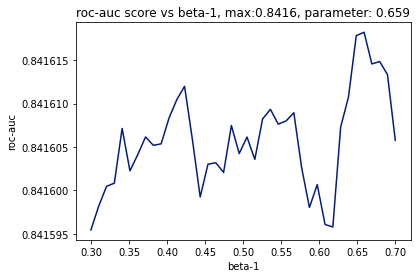

In [123]:
# plot
plt.plot(beta_ones,roc_scores)
max_roc = max(roc_scores)
max_index = roc_scores.index(max_roc)
max_param = round(beta_ones[max_index],4)
max_roc = round(max_roc,4)
plt.ylabel('roc-auc')
plt.xlabel('beta-1')
plt.title(f'roc-auc score vs beta-1, max:{max_roc}, parameter: {max_param}')
plt.show()

#### 5. Activation Function

In [17]:
acs = ['identity','logistic','tanh','relu']
roc_scores = []

for ac in acs:
    neuralNet = MLPClassifier(
        hidden_layer_sizes=(10)
        , activation=ac
        , solver='adam'
        , max_iter=100
        , alpha = 0.02
        , beta_1 = 0.68
        , random_state=1
    )
    neuralNet.fit(train_X_res, train_y_res)
    #confusionMatrices(neuralNet, 'Neural Network')
    neuralNet_pred = neuralNet.predict(test_X)
    this_roc = evalMetrics(neuralNet,neuralNet_pred,verbose=False)['roc_auc']
    roc_scores.append(this_roc)

#### 5b. Visualization

In [144]:
# plot
plt.plot(acs,roc_scores)
max_roc = max(roc_scores)
max_index = roc_scores.index(max_roc)
max_param = acs[max_index]
plt.ylabel('roc-auc')
plt.xlabel('activations')
plt.title(f'roc-auc score vs activations, max:{max_roc}, parameter: {max_param}')
plt.show()

NameError: name 'acs' is not defined

#### 6. Epsilon

In [25]:
epsilons = [float(x) for x in np.linspace(1e-10,1e-8, num = 10)] 
roc_scores = []
for e in epsilons:
    neuralNet = MLPClassifier(
        hidden_layer_sizes=(10)
        , activation='logistic'
        , solver='adam'
        , max_iter=100
        , alpha = 0.02
        , beta_1 = 0.68
        , random_state=1
        , epsilon= e
    )
    neuralNet.fit(train_X_res, train_y_res)
    #confusionMatrices(neuralNet, 'Neural Network')
    neuralNet_pred = neuralNet.predict(test_X)
    this_roc = evalMetrics(neuralNet,neuralNet_pred,verbose=False)['roc_auc']
    roc_scores.append(this_roc)

#### 6b. Visualization

In [ ]:
# plot
plt.plot(epsilons,roc_scores)
max_roc = max(roc_scores)
max_index = roc_scores.index(max_roc)
max_param = epsilons[max_index]

plt.title(f'roc-auc score vs epsilon, max:{max_roc}, parameter: {max_param}')
plt.ylabel('roc-auc')
plt.xlabel('epsilon')
plt.show()

In [97]:
import xgboost as xgb
from hyperopt import hp
space = {'max_depth': hp.quniform("max_depth", 3, 18, 1),
         'gamma': hp.uniform('gamma', 1, 9),
         'reg_alpha': hp.quniform('reg_alpha', 30, 180, 1),
         'reg_lambda': hp.uniform('reg_lambda', 0, 1),
         'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
         'min_child_weight': hp.quniform('min_child_weight', 0, 10, 1),
         'n_estimators': hp.choice("n_estimators", num_estimator),
         }



### Final Models Based on Tuning

#### Logistic Regression

In [80]:
lr = LogisticRegression(random_state=1,C=0.0001,penalty='none')
lr.fit(train_X_res,train_y_res)
lr

LogisticRegression(C=0.0001, penalty='none', random_state=1)

In [91]:
logit_pred = lr.predict(test_X)
lr_probs = lr.predict_proba(test_X)

#### Naive Bayes

In [72]:
gnb = GaussianNB()
gnb.fit(train_X_res,train_y_res)
gnb

GaussianNB()

In [82]:
gnb_pred = gnb.predict(test_X)
gnb_probs = gnb.predict_proba(test_X)

#### Random Forest

In [148]:
rf = RandomForest = RandomForestClassifier(
        n_estimators= 200
        , random_state=1
        , max_depth = 7
        , min_samples_split = 24
        , min_samples_leaf=150
        , criterion = c 
    )
rf.fit(train_X_res,train_y_res)
rf

RandomForestClassifier(criterion='log_loss', max_depth=7, min_samples_leaf=150,
                       min_samples_split=24, n_estimators=200, random_state=1)

In [149]:
RandomForest_pred = rf.predict(test_X)
rf_probs = rf.predict_proba(test_X)

#### Neural Network

In [74]:
neuralNet = MLPClassifier(
    hidden_layer_sizes=(10)
    , activation='logistic'
    , solver='adam'
    , max_iter=100
    , alpha = 0.02
    , beta_1 = 0.68
    , random_state=1
    , epsilon= 1e-8
)
neuralNet.fit(train_X_res,train_y_res)
neuralNet

MLPClassifier(activation='logistic', alpha=0.02, beta_1=0.68,
              hidden_layer_sizes=10, max_iter=100, random_state=1)

In [84]:
neuralNet_pred = neuralNet.predict(test_X)
nn_probs = neuralNet.predict_proba(test_X)

In [150]:
table = {'Models':["Logistic Regression", 
                   "Random Forest",
                   "Neural Network",
                   "Naive Bayes"],
         'Accuracy':[accuracy_score(test_y, logit_pred), 
                     accuracy_score(test_y, RandomForest_pred),
                     accuracy_score(test_y, neuralNet_pred),
                     accuracy_score(test_y, gnb_pred)],
         'Precision':[precision_score(test_y, logit_pred),
                      precision_score(test_y, RandomForest_pred),
                      precision_score(test_y, neuralNet_pred), 
                      precision_score(test_y, gnb_pred)
                     ],
         "Recall":[recall_score(test_y, logit_pred),
                   recall_score(test_y, RandomForest_pred),
                   recall_score(test_y,neuralNet_pred),
                   recall_score(test_y,gnb_pred)
                  ],
         "F1_Score":[f1_score(test_y, logit_pred),
                     f1_score(test_y, RandomForest_pred),
                     f1_score(test_y,neuralNet_pred),
                     f1_score(test_y,gnb_pred)
                    ],
         "ROC AUC":[roc_auc_score(test_y, lr_probs[:, 1]),
                    roc_auc_score(test_y, rf_probs[:, 1]),
                    roc_auc_score(test_y,  nn_probs[:, 1]),
                    roc_auc_score(test_y, gnb_probs[:, 1])
                   ]
}
table_report = pd.DataFrame(table)
# print the data
table_report

,Models,Accuracy,Precision,Recall,F1_Score,ROC AUC
0,Logistic Regression,0.781641,0.092742,0.718455,0.164279,0.831921
1,Random Forest,0.816205,0.107493,0.705579,0.186564,0.838299
2,Neural Network,0.812077,0.105378,0.706438,0.183398,0.841615
3,Naive Bayes,0.720462,0.074989,0.737339,0.136133,0.816283


Our team chose to optimize on ROC-AUC score, with parsimony as a major consideration. In this case, we select the Random Forest model for its performance relative to the Neural Net on ROC, its relatively high accuracy and precision, high recall, and F1-Score.

In [151]:
import pickle
ename = 'finalized_rf_model.sav'
pickle.dump(rf, open(filename, 'wb'))

In [152]:
#sanity check - reload form pickle
loaded_model = pickle.load(open(filename, 'rb'))
loaded_model

RandomForestClassifier(criterion='log_loss', max_depth=7, min_samples_leaf=150,
                       min_samples_split=24, n_estimators=200, random_state=1)